# Cats vs Dog image classification in Deep Learning using Convolutional neural network (CNN) in PyTorch

# Introduction

This dataset is slightly different from the dataset used in the TensorFlow notebook.

The dataset comes from the Kaggle Dogs vs. Cats Redux: Kernels Edition (URL: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

The Kaggle competition has ended for a long time, but it is still possible to submit the results.

**My goal is to create a CNN with PyTorch that can recognize a cat or a dog from an image. I am not here to improve the score or have the best parameters, but I can give you some clues on this notebook.** 

In this Kaggle, the score uses the loss function to determine if the model makes many or few errors.

This loss function uses the Binary Cross Entropy :

\begin{equation*}
-\frac{1}{N}\sum_{i=1}^{N} y_i\log(p_i) + (1-y_i)\log(1-p_i)
\end{equation*}

# Check the GPU compatible with CUDA to run the code during the training model faster

You have to check if a GPU compatible with CUDA is available. 

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("A CUDA-compatible GPU is available.")
else:
    device = torch.device("cpu")
    print("No CUDA-compatible GPU is available.")
    
torch.manual_seed(1234)

if device == 'cuda':
    torch.cuda.manual_seed_all(1234)

No CUDA-compatible GPU is available.


# Removing files

In [2]:
!rm readme[1].txt
!rm /content/CDLA-Permissive-2.0.pdf
!rm /content/kagglecatsanddogs_5340.zip
!rm -r /content/train/train
!rm -r train
!rm -r /content/test/test
!rm -r test
!rm /content/dogs-vs-cats-redux-kernels-edition.zip
!rm /content/sample_submission.csv
!rm /content/test.zip
!rm /content/train.zip
!rm /content/result.csv

rm: cannot remove 'readme[1].txt': No such file or directory
rm: cannot remove '/content/CDLA-Permissive-2.0.pdf': No such file or directory
rm: cannot remove '/content/kagglecatsanddogs_5340.zip': No such file or directory


# Dataset Information

The dataset comprises 25,000 images of both dogs and cats, which will be used to train our algorithm and make predictions on their respective labels.

We also consider that :

- 1 = Dog 
- 0 : Cat

# Download Dataset

You can dowload the Dataset directly on Kaggle.

**Before that, you have to install the Kaggle library.**

```
# !pip install kaggle
```

**Then, you have download the kaggle.json file :**  

Settings => Create New Token

In [3]:
# Configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

You have to go there : https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data

Then, you have to copy and paste the Kaggel API : 

```
# !kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
```

In [4]:
# Kaggle API 
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 809M/814M [00:06<00:00, 153MB/s]
100% 814M/814M [00:06<00:00, 126MB/s]


# Import libraries

In [5]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import random
import seaborn as sns
sns.set(style="darkgrid")

# Deal with the file
from PIL import Image
from zipfile import ZipFile
import glob
import os
from itertools import zip_longest

# Split our dataset
from sklearn.model_selection import train_test_split

# Unzip files

In [6]:
!ls

cat.jpg  dogs-vs-cats-redux-kernels-edition.zip  kaggle.json  sample_data


In [7]:
# Set the path to the zip file
zip_path = "/content/dogs-vs-cats-redux-kernels-edition.zip"

# Extract the contents of the zip file to the current working directory
with ZipFile(zip_path, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [8]:
!ls

cat.jpg					sample_data	       train.zip
dogs-vs-cats-redux-kernels-edition.zip	sample_submission.csv
kaggle.json				test.zip


In [9]:
# Set the paths to the zip files
zip_paths = ["/content/test.zip", "/content/train.zip"]

# Extract the contents of each zip file to a directory
for zip_path in zip_paths:
    with ZipFile(zip_path, 'r') as zip:
        if 'test' in zip_path:
            destination_dir = "/content/test"
        else:
            destination_dir = "/content/train"
        zip.extractall(destination_dir)
        print(f"The contents of {zip_path} are extracted to {destination_dir}")

The contents of /content/test.zip are extracted to /content/test
The contents of /content/train.zip are extracted to /content/train


# Parameters you can adjust to improve the score

In [10]:
learning_rate = 0.001 # 0.001 by default
batch_size = 64 # 100 by default
epochs = 10 # 10 by default 

# Download Data

In [11]:
# Training data

train_dir = '/content/train/train'
img_files_training = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if not f.startswith('.')]

# Testing data

test_dir = '/content/test/test'
img_files_test = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if not f.startswith('.')]

# Display the total number of total training and test images with their first path
def display_data(img_files_training, img_files_test):
  print("Total training images:", len(img_files_training))
  print("First training image path:", img_files_training[0])
  print()
  print("Total test images:", len(img_files_test))
  print("First test image path:", img_files_test[0])

display_data(img_files_training, img_files_test)

Total training images: 25000
First training image path: /content/train/train/cat.7106.jpg

Total test images: 12500
First test image path: /content/test/test/4098.jpg


#Load train and test data

In [12]:
train_dir = '/content/train/train'
test_dir = '/content/test/test'

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

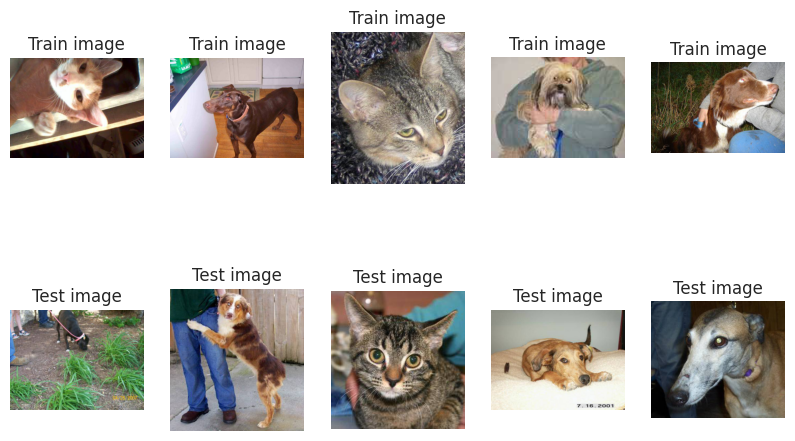

In [13]:
# Visualize our dataset

random_train_idx = np.random.randint(1, 25000, size=5)
random_test_idx = np.random.randint(1, 12500, size=5)

fig, ax = plt.subplots(2, 5, figsize=(10, 6))
ax = ax.flatten()

for i, idx in enumerate(random_train_idx):
    img = Image.open(train_list[idx])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title('Train image')
    
for i, idx in enumerate(random_test_idx):
    img = Image.open(test_list[idx])
    ax[5+i].imshow(img)
    ax[5+i].axis('off')
    ax[5+i].set_title('Test image')

plt.show()

In [14]:
# Split the first file path in the train list by the '/' character and get the last element
# Split the last element by the '.' character and get the first element
# This will give us the name of the first image in the train list without the file extension
train_list[0].split('/')[-1].split('.')[0]

'cat'

# Preprocessing our dataset

In [15]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transforms  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

We will define 1 for dog and 0  for cat.

In [16]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,file_list,transform = None):
        # Set the file list and transform arguments as instance variables
        self.file_list=file_list
        self.transform=transform
    
    def __len__(self):
        # Get the length of the file list and return it
        self.filelength =len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        # Get the image path at the given index
        img_path =self.file_list[idx]
        
        # Open the image using PIL and apply the specified transform
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        # Extract the label from the image file name and convert to an integer
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
        
        # Return the transformed image and its corresponding label
        return img_transformed,label

# Exploratory Data Analysis

We will display a grid of images to visualize the contents of the dataset.

100%|██████████| 25000/25000 [02:59<00:00, 139.34it/s]


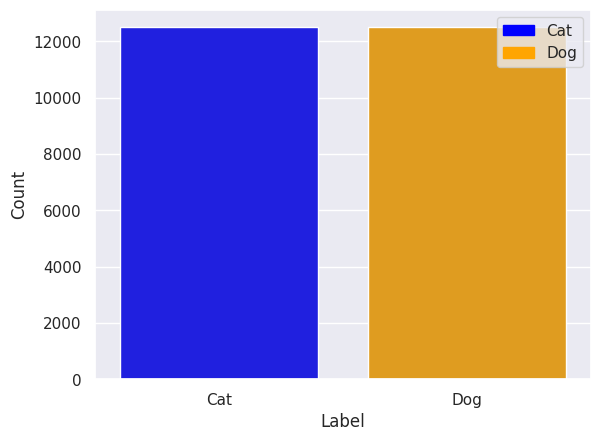

In [17]:
train_dataset = dataset(train_list, transform=train_transforms)
train_labels = []

# Iterate over each image in the dataset and extract its label
for i in tqdm(range(len(train_dataset))):
    label = train_dataset[i][1]
    
    # Convert the integer label to a string representation ('Dog' or 'Cat')
    if label == 1:
        train_labels.append('Dog')
    else:
        train_labels.append('Cat')

# Define the label names and colors for the plot
label_names = ['Cat', 'Dog']
label_colors = {'Cat': 'Blue', 'Dog': 'Orange'}

# Use seaborn to create a bar plot of the image labels and their counts
sns.countplot(x=train_labels, palette=label_colors)

# Set the x-axis labels to the label names and add x and y axis labels
plt.xticks([0, 1], label_names)
plt.xlabel('Label')
plt.ylabel('Count')

# Add a legend to the plot using the label colors
handles = [plt.Rectangle((0,0),1,1, color=color) for color in label_colors.values()]
plt.legend(handles, label_colors.keys())

# Show the plot
plt.show()


We can see an equal distribution of both classes which is good.

We will split the train and test set.

In [18]:
train_list,val_list = train_test_split(train_list , test_size =0.2)

We call the class dataset in order to transform our image and put the labels.

In [19]:
train_data = dataset(train_list,transform=train_transforms)
test_data = dataset(test_list,transform=test_transforms)
val_data = dataset(val_list,transform=test_transforms)

I create 3 data loaders for the training, validation, and test datasets respectively, with a specified batch size and shuffling option. 

These data loaders are used to feed the data into your model during training, validation, and testing.

In [20]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle = True)

Let's see our the number of samples in the training/test dataset and the number of batches that the training/test dataset is divided into (based on the specified batch size).



In [21]:
print(len(train_data),len(train_loader))
print(len(val_data), len(val_loader))
print(len(test_data),len(test_loader))

20000 313
5000 79
12500 196


We can watch the size of the tensor.

In [22]:
torch.Size([3, 224, 224])

torch.Size([3, 224, 224])

It represents the a tensor with 3 channels, and a spatial resolution of 224 by 224 pixels.

# Pytorch implementation of CNN Architecture

In [23]:
class Cnn(nn.Module):

    def __init__(self):
        super(Cnn,self).__init__()
        
        # Layer 1: Convolution, BatchNorm, ReLU activation, and Max pooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Layer 2: Convolution, BatchNorm, ReLU activation, and Max pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Layer 3: Convolution, BatchNorm, ReLU activation, and Max pooling
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Fully connected layers with ReLU activation and dropout
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # Pass the input through the three convolutional layers
        out =self.layer1(x)
        out =self.layer2(out)
        out =self.layer3(out)
        
        # Flatten the output tensor and pass through fully connected layers
        out =out.view(out.size(0),-1)
        out =self.relu(self.fc1(out))
        out =self.fc2(out)
        
        return out

We will initializes an instance of the CNN model, sets it to training mode, defines an Adam optimizer with a learning rate of 0.001, and sets the loss function to Cross Entropy Loss.

In [24]:
model = Cnn()
model.train()
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

# Training our CNN

**The training is very long to run if you don't have a good GPU Hardware or if you don't execute GPU in Colab (55 minutes for me).**

In [25]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

model.to(device)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    # Set the model in training mode
    model.train()
    
    # Initialize progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    # Loop through the training data batches
    for data, label in progress_bar:
        # Move data and labels to the device (GPU)
        data = data.to(device)
        label = label.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, label)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training accuracy and loss
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        
        # Update progress bar
        progress_bar.set_postfix({'Training Loss': epoch_loss.item(), 'Training Accuracy': epoch_accuracy.item()})

    # Append epoch training loss and accuracy to lists
    train_loss_list.append(epoch_loss.item())
    train_acc_list.append(epoch_accuracy.item())

    # Evaluate the model on validation set
    with torch.no_grad():
        epoch_val_loss = 0
        epoch_val_accuracy = 0

        # Set the model to evaluation mode
        model.eval()

        # Create a progress bar for the validation set
        progress_bar = tqdm(val_loader, desc=f"Validation {epoch+1}")

        # Loop through the validation set
        for data, label in progress_bar:
            # Move the data and labels to the device
            data = data.to(device)
            label = label.to(device)

            # Compute the validation output and loss
            val_output = model(data)
            val_loss = criterion(val_output, label)

            # Compute the validation accuracy
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

            # Update the progress bar with the current loss and accuracy
            progress_bar.set_postfix({'Validation Loss': epoch_val_loss.item(), 'Validation Accuracy': epoch_val_accuracy.item()})

        # Append the validation loss and accuracy to their respective lists
        val_loss_list.append(epoch_val_loss.item())
        val_acc_list.append(epoch_val_accuracy.item())
        
    print('Epoch: {}, train accuracy: {:.4f}, train loss: {:.4f}, val accuracy: {:.4f}, val loss: {:.4f}'
          .format(epoch + 1, epoch_accuracy.item(), epoch_loss.item(), epoch_val_accuracy.item(), epoch_val_loss.item()))

Validation 1: 100%|██████████| 79/79 [00:56<00:00,  1.40it/s, Validation Loss=0.59, Validation Accuracy=0.684]


Epoch: 1, train accuracy: 0.6425, train loss: 0.6256, val accuracy: 0.6841, val loss: 0.5900


Validation 2: 100%|██████████| 79/79 [00:52<00:00,  1.51it/s, Validation Loss=0.555, Validation Accuracy=0.717]


Epoch: 2, train accuracy: 0.7080, train loss: 0.5614, val accuracy: 0.7172, val loss: 0.5550


Validation 3: 100%|██████████| 79/79 [01:16<00:00,  1.03it/s, Validation Loss=0.538, Validation Accuracy=0.723]


Epoch: 3, train accuracy: 0.7258, train loss: 0.5379, val accuracy: 0.7235, val loss: 0.5382


Validation 4: 100%|██████████| 79/79 [01:05<00:00,  1.21it/s, Validation Loss=0.512, Validation Accuracy=0.749]


Epoch: 4, train accuracy: 0.7369, train loss: 0.5216, val accuracy: 0.7488, val loss: 0.5121


Validation 5: 100%|██████████| 79/79 [00:58<00:00,  1.34it/s, Validation Loss=0.484, Validation Accuracy=0.761]


Epoch: 5, train accuracy: 0.7487, train loss: 0.4986, val accuracy: 0.7609, val loss: 0.4845


Validation 6: 100%|██████████| 79/79 [00:57<00:00,  1.38it/s, Validation Loss=0.624, Validation Accuracy=0.688]


Epoch: 6, train accuracy: 0.7583, train loss: 0.4900, val accuracy: 0.6881, val loss: 0.6240


Validation 7: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s, Validation Loss=0.486, Validation Accuracy=0.759]


Epoch: 7, train accuracy: 0.7630, train loss: 0.4815, val accuracy: 0.7587, val loss: 0.4857


Validation 8: 100%|██████████| 79/79 [00:48<00:00,  1.62it/s, Validation Loss=0.508, Validation Accuracy=0.766]


Epoch: 8, train accuracy: 0.7752, train loss: 0.4650, val accuracy: 0.7658, val loss: 0.5082


Validation 9: 100%|██████████| 79/79 [00:56<00:00,  1.39it/s, Validation Loss=0.5, Validation Accuracy=0.752]


Epoch: 9, train accuracy: 0.7730, train loss: 0.4660, val accuracy: 0.7524, val loss: 0.4998


Validation 10: 100%|██████████| 79/79 [00:55<00:00,  1.41it/s, Validation Loss=0.455, Validation Accuracy=0.782]

Epoch: 10, train accuracy: 0.7795, train loss: 0.4550, val accuracy: 0.7822, val loss: 0.4555


# Plot the learning curve

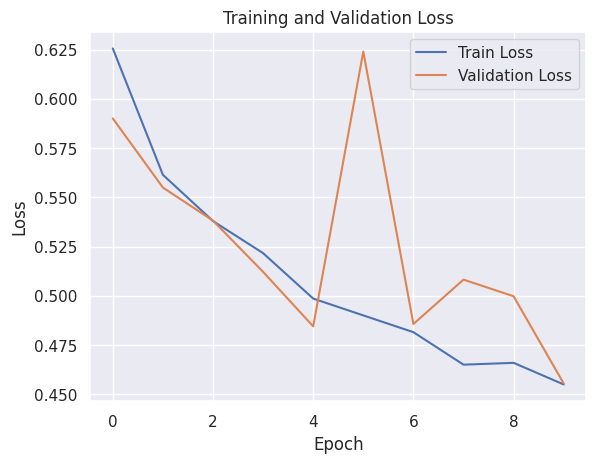

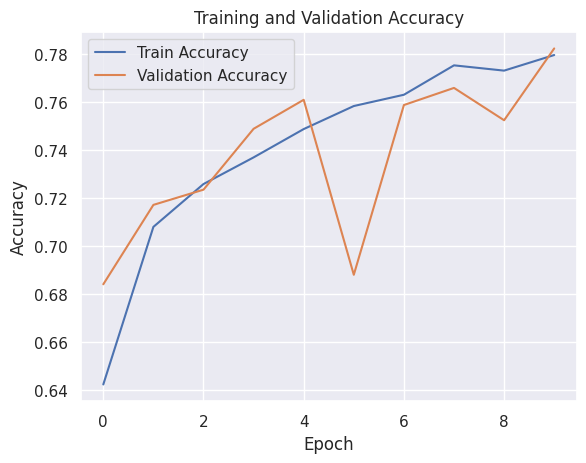

In [26]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print()

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The curve is not perfect because of the variation. I have to put a better parameters or change a little bit the CNN architecture.

Otherwise, even if it's not perfect, the model can recognize a cat or a dog in the picture.

# Submission for Kaggle Competition

In [27]:
dog_probs = []
model.eval()

# Loop through each batch of data in the `test_loader`
for data, fileid in tqdm(test_loader):
    data = data.to(device)
    preds = model(data)

    # Apply the softmax function to obtain probability scores for each class
    preds_list = F.softmax(preds, dim=1)[:, 1].tolist()

    # Extract filename from file path
    fileid = [os.path.basename(f) for f in fileid]

    # Pair each filename with its corresponding probability score using `zip_longest()`
    # and append the resulting list to `dog_probs`
    dog_probs += list(zip_longest(fileid, preds_list))

100%|██████████| 196/196 [02:35<00:00,  1.26it/s]


In [28]:
dog_probs.sort(key = lambda x: int(x[0]))
dog_probs

[('1', 0.9442353844642639),
 ('2', 0.9358375072479248),
 ('3', 0.3615078032016754),
 ('4', 0.9847860932350159),
 ('5', 0.5536096096038818),
 ('6', 0.5857467651367188),
 ('7', 0.06762766093015671),
 ('8', 0.13995064795017242),
 ('9', 0.08860167115926743),
 ('10', 0.06636690348386765),
 ('11', 0.21104389429092407),
 ('12', 0.7553853988647461),
 ('13', 0.19680066406726837),
 ('14', 0.7653903961181641),
 ('15', 0.296401709318161),
 ('16', 0.07306275516748428),
 ('17', 0.9678393006324768),
 ('18', 0.9601076245307922),
 ('19', 0.39240384101867676),
 ('20', 0.32083553075790405),
 ('21', 0.19732004404067993),
 ('22', 0.22114437818527222),
 ('23', 0.4465245306491852),
 ('24', 0.9028609991073608),
 ('25', 0.262033611536026),
 ('26', 0.35949867963790894),
 ('27', 0.8825231194496155),
 ('28', 0.009171697311103344),
 ('29', 0.7591625452041626),
 ('30', 0.9526193737983704),
 ('31', 0.7992182970046997),
 ('32', 0.026629099622368813),
 ('33', 0.9288766384124756),
 ('34', 0.2758421301841736),
 ('35', 0

In [29]:
idx = list(map(lambda x :x[0],dog_probs))
prob = list(map(lambda x :x[1],dog_probs))

In [30]:
submission = pd.DataFrame({'id':idx, 'label':prob})

In [31]:
submission

,id,label
0,1,0.944235
1,2,0.935838
2,3,0.361508
3,4,0.984786
4,5,0.553610
...,...,...
12495,12496,0.045925
12496,12497,0.059363
12497,12498,0.225121
12498,12499,0.993932


In [32]:
submission.to_csv('result.csv',index=False)

# Test the submission

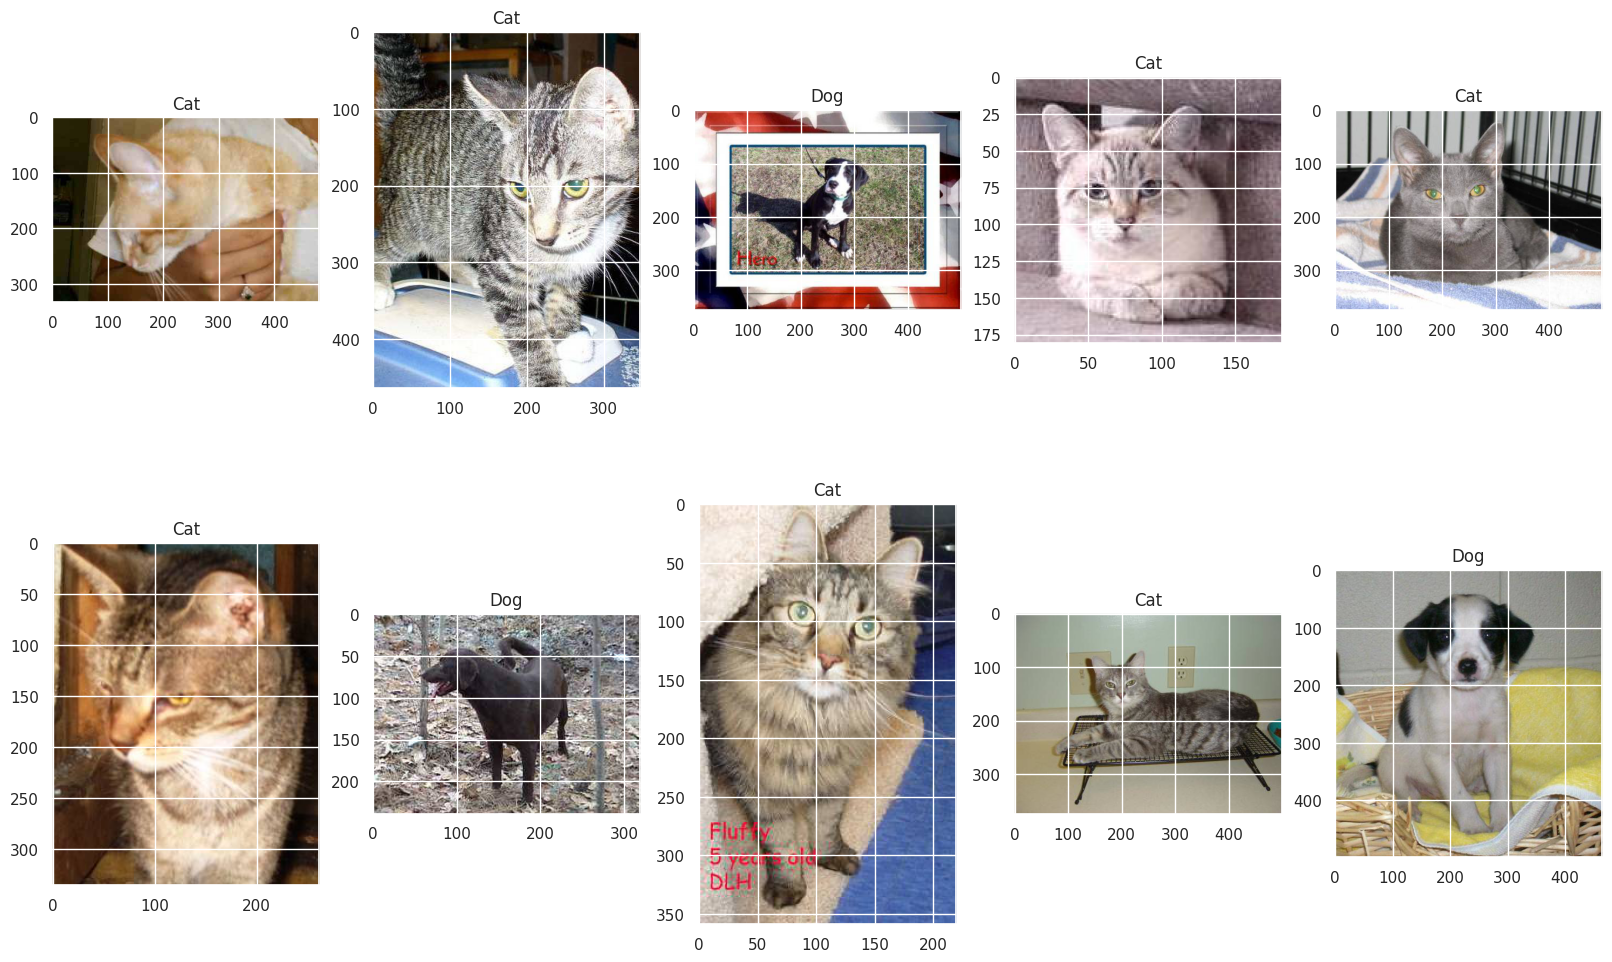

In [39]:
id_list = []
class_ = {0: 'Cat', 1: 'Dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

**Download on Github "cat.jpg" in order to run this notebook.**

In [34]:
# Define the path to the image
image_path = "cat.jpg"

# Load the image and apply transformations
transform = transforms.Compose([
    transforms.Resize((1024, 1024)), # You have to change the Resize sometime to match the prediction correctly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = Image.open(image_path)
img = transform(img)
img = img.unsqueeze(0) # Add batch dimension for prediction

# Load the pre-trained model
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)

# Put the model in evaluation mode
model.eval()

# Make a prediction on the image
with torch.no_grad():
    pred = model(img)

# Convert the prediction to a label
label = 'Dog' if pred[0][0] < 0.1 else 'Cat'
print("Prediction of the image :", pred[0][0])
print(label)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prediction of the image : tensor(0.5292)
Cat


If you want to match the prediction correctly, you have to change the Resize.


# Conclusion

If you use the default parameters :

```
learning_rate = 0.001
batch_size = 100 
epochs = 10
```

I get a score of 0.55388.

When I change the batch_size to 64 :

```
learning_rate = 0.001 # 0.001 by default
batch_size = 64 # 100 by default
epochs = 10 # 10 by default 
```

I have an improvement because the score I get is 0.49517.

I could improve the score of my CNN but if you want a better score, you should change the model for a better improvement.